# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 5578752/11490434 [=============>................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 10:58 - loss: 0.6934

  31/1875 [..............................] - ETA: 3s - loss: 0.5386   

  68/1875 [>.............................] - ETA: 2s - loss: 0.4483

 107/1875 [>.............................] - ETA: 2s - loss: 0.4033

 142/1875 [=>............................] - ETA: 2s - loss: 0.3781

 176/1875 [=>............................] - ETA: 2s - loss: 0.3600

 211/1875 [==>...........................] - ETA: 2s - loss: 0.3454

 249/1875 [==>...........................] - ETA: 2s - loss: 0.3324

 293/1875 [===>..........................] - ETA: 2s - loss: 0.3200

 333/1875 [====>.........................] - ETA: 2s - loss: 0.3104

 371/1875 [====>.........................] - ETA: 2s - loss: 0.3025

 409/1875 [=====>........................] - ETA: 2s - loss: 0.2955

 448/1875 [======>.......................] - ETA: 1s - loss: 0.2890

 491/1875 [======>.......................] - ETA: 1s - loss: 0.2826

 529/1875 [=======>......................] - ETA: 1s - loss: 0.2774

 565/1875 [========>.....................] - ETA: 1s - loss: 0.2729

 602/1875 [========>.....................] - ETA: 1s - loss: 0.2686

 640/1875 [=========>....................] - ETA: 1s - loss: 0.2646

 678/1875 [=========>....................] - ETA: 1s - loss: 0.2608

 713/1875 [==========>...................] - ETA: 1s - loss: 0.2575

 746/1875 [==========>...................] - ETA: 1s - loss: 0.2546

 785/1875 [===========>..................] - ETA: 1s - loss: 0.2513

 818/1875 [============>.................] - ETA: 1s - loss: 0.2487

 856/1875 [============>.................] - ETA: 1s - loss: 0.2459

 884/1875 [=============>................] - ETA: 1s - loss: 0.2439

 920/1875 [=============>................] - ETA: 1s - loss: 0.2414

 959/1875 [==============>...............] - ETA: 1s - loss: 0.2389

 996/1875 [==============>...............] - ETA: 1s - loss: 0.2365

1031/1875 [===============>..............] - ETA: 1s - loss: 0.2345

1071/1875 [================>.............] - ETA: 1s - loss: 0.2322

1109/1875 [================>.............] - ETA: 1s - loss: 0.2301

1148/1875 [=================>............] - ETA: 1s - loss: 0.2281

1184/1875 [=================>............] - ETA: 0s - loss: 0.2263

1221/1875 [==================>...........] - ETA: 0s - loss: 0.2245

1260/1875 [===================>..........] - ETA: 0s - loss: 0.2226

1297/1875 [===================>..........] - ETA: 0s - loss: 0.2210

1335/1875 [====================>.........] - ETA: 0s - loss: 0.2193

1374/1875 [====================>.........] - ETA: 0s - loss: 0.2177

1411/1875 [=====================>........] - ETA: 0s - loss: 0.2162

1449/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1483/1875 [======================>.......] - ETA: 0s - loss: 0.2134

1519/1875 [=======================>......] - ETA: 0s - loss: 0.2121

1559/1875 [=======================>......] - ETA: 0s - loss: 0.2107

1596/1875 [========================>.....] - ETA: 0s - loss: 0.2094

1635/1875 [=========================>....] - ETA: 0s - loss: 0.2081

1672/1875 [=========================>....] - ETA: 0s - loss: 0.2068

1711/1875 [==========================>...] - ETA: 0s - loss: 0.2056

1748/1875 [==========================>...] - ETA: 0s - loss: 0.2045

1785/1875 [===========================>..] - ETA: 0s - loss: 0.2033

1823/1875 [============================>.] - ETA: 0s - loss: 0.2022

1861/1875 [============================>.] - ETA: 0s - loss: 0.2011

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2007


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1195

  37/1875 [..............................] - ETA: 2s - loss: 0.1101

  71/1875 [>.............................] - ETA: 2s - loss: 0.1094

 106/1875 [>.............................] - ETA: 2s - loss: 0.1090

 144/1875 [=>............................] - ETA: 2s - loss: 0.1088

 183/1875 [=>............................] - ETA: 2s - loss: 0.1086

 221/1875 [==>...........................] - ETA: 2s - loss: 0.1084

 260/1875 [===>..........................] - ETA: 2s - loss: 0.1082

 298/1875 [===>..........................] - ETA: 2s - loss: 0.1081

 336/1875 [====>.........................] - ETA: 2s - loss: 0.1079

 374/1875 [====>.........................] - ETA: 2s - loss: 0.1078

 412/1875 [=====>........................] - ETA: 1s - loss: 0.1077

 451/1875 [======>.......................] - ETA: 1s - loss: 0.1076

 490/1875 [======>.......................] - ETA: 1s - loss: 0.1074

 528/1875 [=======>......................] - ETA: 1s - loss: 0.1073

 567/1875 [========>.....................] - ETA: 1s - loss: 0.1072

 604/1875 [========>.....................] - ETA: 1s - loss: 0.1071

 642/1875 [=========>....................] - ETA: 1s - loss: 0.1070

 680/1875 [=========>....................] - ETA: 1s - loss: 0.1069

 717/1875 [==========>...................] - ETA: 1s - loss: 0.1068

 756/1875 [===========>..................] - ETA: 1s - loss: 0.1067

 794/1875 [===========>..................] - ETA: 1s - loss: 0.1066

 832/1875 [============>.................] - ETA: 1s - loss: 0.1065

 871/1875 [============>.................] - ETA: 1s - loss: 0.1065

 909/1875 [=============>................] - ETA: 1s - loss: 0.1064

 947/1875 [==============>...............] - ETA: 1s - loss: 0.1063

 986/1875 [==============>...............] - ETA: 1s - loss: 0.1062

1024/1875 [===============>..............] - ETA: 1s - loss: 0.1061

1063/1875 [================>.............] - ETA: 1s - loss: 0.1060

1103/1875 [================>.............] - ETA: 1s - loss: 0.1059

1142/1875 [=================>............] - ETA: 0s - loss: 0.1058

1181/1875 [=================>............] - ETA: 0s - loss: 0.1058

1221/1875 [==================>...........] - ETA: 0s - loss: 0.1057

1261/1875 [===================>..........] - ETA: 0s - loss: 0.1056

1300/1875 [===================>..........] - ETA: 0s - loss: 0.1055

1339/1875 [====================>.........] - ETA: 0s - loss: 0.1055

1378/1875 [=====================>........] - ETA: 0s - loss: 0.1054

1417/1875 [=====================>........] - ETA: 0s - loss: 0.1053

1456/1875 [======================>.......] - ETA: 0s - loss: 0.1052

1495/1875 [======================>.......] - ETA: 0s - loss: 0.1052

1534/1875 [=======================>......] - ETA: 0s - loss: 0.1051

1573/1875 [========================>.....] - ETA: 0s - loss: 0.1050

1612/1875 [========================>.....] - ETA: 0s - loss: 0.1050

1651/1875 [=========================>....] - ETA: 0s - loss: 0.1049

1690/1875 [==========================>...] - ETA: 0s - loss: 0.1049

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1048

1759/1875 [===========================>..] - ETA: 0s - loss: 0.1048

1796/1875 [===========================>..] - ETA: 0s - loss: 0.1047

1828/1875 [============================>.] - ETA: 0s - loss: 0.1047

1861/1875 [============================>.] - ETA: 0s - loss: 0.1046

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1046


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1036

  35/1875 [..............................] - ETA: 2s - loss: 0.0972

  69/1875 [>.............................] - ETA: 2s - loss: 0.0973

 102/1875 [>.............................] - ETA: 2s - loss: 0.0973

 136/1875 [=>............................] - ETA: 2s - loss: 0.0973

 175/1875 [=>............................] - ETA: 2s - loss: 0.0973

 214/1875 [==>...........................] - ETA: 2s - loss: 0.0973

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0973

 292/1875 [===>..........................] - ETA: 2s - loss: 0.0974

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0974

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0974

 406/1875 [=====>........................] - ETA: 2s - loss: 0.0974

 444/1875 [======>.......................] - ETA: 1s - loss: 0.0974

 482/1875 [======>.......................] - ETA: 1s - loss: 0.0974

 520/1875 [=======>......................] - ETA: 1s - loss: 0.0974

 547/1875 [=======>......................] - ETA: 1s - loss: 0.0974

 577/1875 [========>.....................] - ETA: 1s - loss: 0.0974

 615/1875 [========>.....................] - ETA: 1s - loss: 0.0974

 653/1875 [=========>....................] - ETA: 1s - loss: 0.0974

 691/1875 [==========>...................] - ETA: 1s - loss: 0.0974

 729/1875 [==========>...................] - ETA: 1s - loss: 0.0974

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0974

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0974

 846/1875 [============>.................] - ETA: 1s - loss: 0.0974

 885/1875 [=============>................] - ETA: 1s - loss: 0.0974

 923/1875 [=============>................] - ETA: 1s - loss: 0.0974

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0974

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0974

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0974

1076/1875 [================>.............] - ETA: 1s - loss: 0.0974

1115/1875 [================>.............] - ETA: 1s - loss: 0.0974

1153/1875 [=================>............] - ETA: 0s - loss: 0.0974

1191/1875 [==================>...........] - ETA: 0s - loss: 0.0974

1229/1875 [==================>...........] - ETA: 0s - loss: 0.0974

1267/1875 [===================>..........] - ETA: 0s - loss: 0.0974

1305/1875 [===================>..........] - ETA: 0s - loss: 0.0974

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1514/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1819/1875 [============================>.] - ETA: 0s - loss: 0.0973

1858/1875 [============================>.] - ETA: 0s - loss: 0.0973

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0973


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0926

  40/1875 [..............................] - ETA: 2s - loss: 0.0947

  79/1875 [>.............................] - ETA: 2s - loss: 0.0949

 118/1875 [>.............................] - ETA: 2s - loss: 0.0949

 157/1875 [=>............................] - ETA: 2s - loss: 0.0950

 196/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 235/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 312/1875 [===>..........................] - ETA: 2s - loss: 0.0953

 352/1875 [====>.........................] - ETA: 1s - loss: 0.0953

 392/1875 [=====>........................] - ETA: 1s - loss: 0.0954

 432/1875 [=====>........................] - ETA: 1s - loss: 0.0954

 472/1875 [======>.......................] - ETA: 1s - loss: 0.0954

 512/1875 [=======>......................] - ETA: 1s - loss: 0.0954

 552/1875 [=======>......................] - ETA: 1s - loss: 0.0954

 592/1875 [========>.....................] - ETA: 1s - loss: 0.0954

 632/1875 [=========>....................] - ETA: 1s - loss: 0.0954

 673/1875 [=========>....................] - ETA: 1s - loss: 0.0955

 713/1875 [==========>...................] - ETA: 1s - loss: 0.0955

 753/1875 [===========>..................] - ETA: 1s - loss: 0.0955

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0955

 833/1875 [============>.................] - ETA: 1s - loss: 0.0955

 873/1875 [============>.................] - ETA: 1s - loss: 0.0955

 913/1875 [=============>................] - ETA: 1s - loss: 0.0955

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1088/1875 [================>.............] - ETA: 1s - loss: 0.0956

1126/1875 [=================>............] - ETA: 0s - loss: 0.0956

1160/1875 [=================>............] - ETA: 0s - loss: 0.0956

1192/1875 [==================>...........] - ETA: 0s - loss: 0.0956

1221/1875 [==================>...........] - ETA: 0s - loss: 0.0956

1257/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1296/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1842/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0956


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1009

  40/1875 [..............................] - ETA: 2s - loss: 0.0963

  79/1875 [>.............................] - ETA: 2s - loss: 0.0960

 118/1875 [>.............................] - ETA: 2s - loss: 0.0960

 156/1875 [=>............................] - ETA: 2s - loss: 0.0960

 195/1875 [==>...........................] - ETA: 2s - loss: 0.0959

 233/1875 [==>...........................] - ETA: 2s - loss: 0.0959

 273/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 312/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 351/1875 [====>.........................] - ETA: 1s - loss: 0.0958

 390/1875 [=====>........................] - ETA: 1s - loss: 0.0958

 429/1875 [=====>........................] - ETA: 1s - loss: 0.0957

 468/1875 [======>.......................] - ETA: 1s - loss: 0.0957

 507/1875 [=======>......................] - ETA: 1s - loss: 0.0957

 546/1875 [=======>......................] - ETA: 1s - loss: 0.0957

 581/1875 [========>.....................] - ETA: 1s - loss: 0.0957

 617/1875 [========>.....................] - ETA: 1s - loss: 0.0957

 651/1875 [=========>....................] - ETA: 1s - loss: 0.0957

 678/1875 [=========>....................] - ETA: 1s - loss: 0.0957

 713/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 748/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 819/1875 [============>.................] - ETA: 1s - loss: 0.0956

 851/1875 [============>.................] - ETA: 1s - loss: 0.0956

 877/1875 [=============>................] - ETA: 1s - loss: 0.0956

 911/1875 [=============>................] - ETA: 1s - loss: 0.0956

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1063/1875 [================>.............] - ETA: 1s - loss: 0.0956

1102/1875 [================>.............] - ETA: 1s - loss: 0.0956

1141/1875 [=================>............] - ETA: 1s - loss: 0.0956

1180/1875 [=================>............] - ETA: 0s - loss: 0.0956

1219/1875 [==================>...........] - ETA: 0s - loss: 0.0956

1258/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1299/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1338/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1831/1875 [============================>.] - ETA: 0s - loss: 0.0955

1869/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

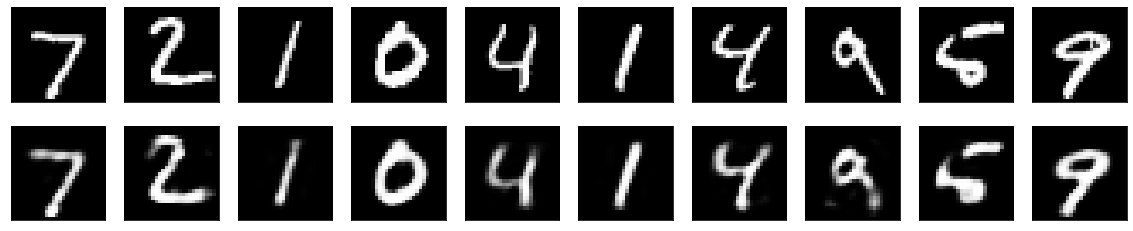

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
